# 11.2 Supervised Models for Return Prediction (Classification & Regression)
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:
- load the engineered features built in Notebook 01,
- define clear prediction targets (next-day return and next-day direction),
- train and evaluate baseline, linear and tree-based models,
- use proper time-based splits instead of random splits,
- analyse feature importance and quantify how hard it is to predict returns.

**This notebook**: 

The emphasis is not on “beating the market”, but on understanding what standard ML models can and cannot do on noisy financial data.

# 0. Setup & Data Loading

In Notebook 01, we engineered a rich set of features from daily prices (returns, volatility, momentum, structural features, etc.) and saved them together with the prediction target in a single Parquet file. We now load this Parquet file, reconstruct X (features) and y (next-day log return), build a classification target from the same y, and inspect shapes and basic distributions.
By default, all features and targets are derived from SPY daily data.

We will respect temporal ordering throughout the entire notebook.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

# Load features + target output from Notebook 01
df_full = pd.read_parquet("features_target_marketdata.parquet")

df_full.head()

,Date,ret_log,ret_log_lag1,ret_log_lag5,ret_log_lag20,ret_log_z20,vol_5,vol_10,vol_20,vol_60,...,sma_20,sma_50,ema_20,rsi_14,macd,macd_signal,macd_hist,drawdown,ret_log_autocorr_1_60,y_next_ret_log
0,2015-03-27,0.002287,-0.002384,0.008788,-0.003412,0.373412,0.006396,0.008748,0.008693,0.008653,...,173.656056,172.655002,173.523297,46.140542,-0.053570,0.228020,-0.281590,-0.025151,-0.097248,0.012126
1,2015-03-30,0.012126,0.002287,-0.001950,0.006294,1.415236,0.009920,0.008566,0.009040,0.008448,...,173.539021,172.780757,173.589321,59.911480,0.014936,0.185403,-0.170467,-0.013258,-0.140380,-0.008778
2,2015-03-31,-0.008778,0.012126,-0.005635,-0.004113,-0.856962,0.010325,0.008997,0.009192,0.008435,...,173.382088,172.868897,173.504051,56.326940,-0.053020,0.137718,-0.190738,-0.021881,-0.138158,-0.003543
3,2015-04-01,-0.003543,-0.008778,-0.014762,-0.004225,-0.291520,0.007867,0.007925,0.009180,0.008308,...,173.231682,172.927833,173.368737,48.834276,-0.154376,0.079300,-0.233676,-0.025340,-0.187452,0.003591
4,2015-04-02,0.003591,-0.003543,-0.002384,0.001094,0.469686,0.007879,0.008032,0.009225,0.008007,...,173.102652,172.948846,173.305276,53.802301,-0.182638,0.026912,-0.209550,-0.021834,-0.161331,0.000000


We check the columns and parse the date column.

In [2]:
df_full.columns

Index(['Date', 'ret_log', 'ret_log_lag1', 'ret_log_lag5', 'ret_log_lag20',
       'ret_log_z20', 'vol_5', 'vol_10', 'vol_20', 'vol_60', 'vol_ratio_5_20',
       'vol_ratio_10_60', 'true_range_simplified', 'sma_20', 'sma_50',
       'ema_20', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'drawdown',
       'ret_log_autocorr_1_60', 'y_next_ret_log'],
      dtype='object')

We convert the date column to datetime and set it as index for easier time-based splitting.

In [ ]:
df_full = pd.read_parquet("features_target_marketdata.parquet")
df_full["Date"] = pd.to_datetime(df_full["Date"])

# Set Date as index
df_full = df_full.set_index("Date").sort_index()
df_full.head()

,ret_log,ret_log_lag1,ret_log_lag5,ret_log_lag20,ret_log_z20,vol_5,vol_10,vol_20,vol_60,vol_ratio_5_20,...,sma_20,sma_50,ema_20,rsi_14,macd,macd_signal,macd_hist,drawdown,ret_log_autocorr_1_60,y_next_ret_log
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-27,0.002287,-0.002384,0.008788,-0.003412,0.373412,0.006396,0.008748,0.008693,0.008653,0.735794,...,173.656056,172.655002,173.523297,46.140542,-0.053570,0.228020,-0.281590,-0.025151,-0.097248,0.012126
2015-03-30,0.012126,0.002287,-0.001950,0.006294,1.415236,0.009920,0.008566,0.009040,0.008448,1.097374,...,173.539021,172.780757,173.589321,59.911480,0.014936,0.185403,-0.170467,-0.013258,-0.140380,-0.008778
2015-03-31,-0.008778,0.012126,-0.005635,-0.004113,-0.856962,0.010325,0.008997,0.009192,0.008435,1.123238,...,173.382088,172.868897,173.504051,56.326940,-0.053020,0.137718,-0.190738,-0.021881,-0.138158,-0.003543
2015-04-01,-0.003543,-0.008778,-0.014762,-0.004225,-0.291520,0.007867,0.007925,0.009180,0.008308,0.856899,...,173.231682,172.927833,173.368737,48.834276,-0.154376,0.079300,-0.233676,-0.025340,-0.187452,0.003591
2015-04-02,0.003591,-0.003543,-0.002384,0.001094,0.469686,0.007879,0.008032,0.009225,0.008007,0.854047,...,173.102652,172.948846,173.305276,53.802301,-0.182638,0.026912,-0.209550,-0.021834,-0.161331,0.000000


We now define:
- `target_col` = `"y_next_ret_log"` (regression target),
- `feature_cols` = all other columns except the target.

In [8]:
target_col = "y_next_ret_log"
feature_cols = [c for c in df_full.columns if c != target_col]

X = df_full[feature_cols].copy()
y_reg = df_full[target_col].copy()  # regression target

X.shape, y_reg.shape

((2792, 21), (2792,))

We build a classification target from the sign of the next-day return:
- 1 if next-day return > 0
- 0 if next-day return ≤ 0 (we merge 0 and negative moves here for simplicity)

In [ ]:
y_cls = (y_reg > 0).astype(int)

y_cls.value_counts()

y_next_ret_log
1    1484
0    1308
Name: count, dtype: int64

We quickly inspect the distribution of the regression target.

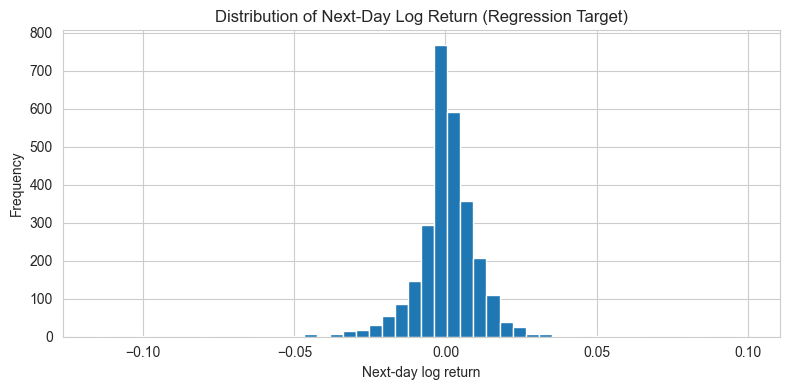

In [ ]:
fig, ax = plt.subplots()
y_reg.dropna().hist(bins=50, ax=ax)
ax.set_title("Distribution of Next-Day Log Return (Regression Target)")
ax.set_xlabel("Next-day log return")
ax.set_ylabel("Frequency")
fig.tight_layout()
plt.show()

And the class balance for the classification target.

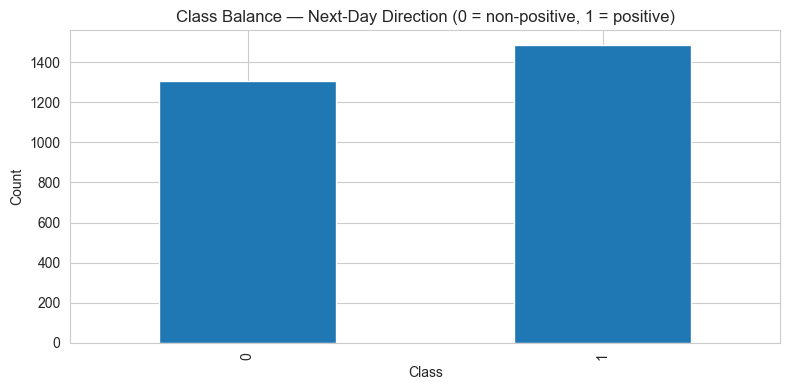

In [ ]:
fig, ax = plt.subplots()
y_cls.value_counts().sort_index().plot(kind="bar", ax=ax)
ax.set_title("Class Balance — Next-Day Direction (0 = non-positive, 1 = positive)")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
fig.tight_layout()
plt.show()

- The next-day log-return target is extremely concentrated around zero, with rare but pronounced tail events typical of equity markets.
- The directional (0/1) target shows only mild imbalance, meaning no dominant class but still very limited structure.
- Both plots confirm that the predictive signal is weak: most movements are tiny, noise dominates, and meaningful patterns are rare and unstable.

# 1. Target Definition & Time-Based Split

We now formalise our prediction tasks:

**Regression:**

$$y_t = r_{t+1}$$

where $r_{t+1}$ is the next-day log-return.

**Classification:**

$$y_t^{\text{cls}} = \mathbb{1}\{r_{t+1} > 0\}$$

The `shift(-1)` has already been applied in Notebook 01 when constructing `y_next_ret_log`. We simply reuse it here.

**We must not use random splits**: doing so would mix future and past in both train and test, which creates temporal leakage. Instead, we choose a cut-off date and train on the past, test on the future.

In [ ]:
split_date = "2020-01-01"

mask_train = X.index < split_date
mask_test = ~mask_train

X_train = X.loc[mask_train].copy()
X_test = X.loc[mask_test].copy()

y_train_reg = y_reg.loc[mask_train].copy()
y_test_reg = y_reg.loc[mask_test].copy()

y_train_cls = y_cls.loc[mask_train].copy()
y_test_cls = y_cls.loc[mask_test].copy()

X_train.shape, X_test.shape, y_train_reg.shape, y_test_reg.shape

((1243, 21), (1549, 21), (1243,), (1549,))

We verify that the split respects time ordering.

In [ ]:
X_train.index.min(), X_train.index.max(), X_test.index.min(), X_test.index.max()

(Timestamp('2015-03-27 00:00:00'),
 Timestamp('2019-12-31 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2025-12-10 00:00:00'))

We deliberately use a time-based split: the training set contains only data strictly before the split date, and the test set corresponds to later periods. This mimics real-life deployment, where we always predict the future based on the past.
A random split would contaminate the training set with information from the future and artificially inflate our performance.

# 2. Baseline Models 

Before using any ML algorithm, we must define baselines:

**Regression baselines:**

- **Zero model**: $\hat{y} = 0$
- **Mean model**: $\hat{y} = \bar{y}_{\text{train}}$
- **Naive "last return"**: $\hat{y}_t = r_t$ (we use the current-day log return as a predictor for the next-day log return)

**Classification baselines:**

- **Majority class**: always predict the most frequent class in the training set
- **Random coin flip**: sample class 0/1 with probabilities equal to the class frequencies in training

We implement the baselines and compute:

- **For regression**: MSE, MAE, $R^2$
- **For classification**: accuracy, balanced accuracy


In [15]:
from collections import OrderedDict

baseline_results_reg = OrderedDict()
baseline_results_cls = OrderedDict()

# Regression baselines

# Zero model
y_pred_zero = np.zeros_like(y_test_reg)
baseline_results_reg["zero"] = {
    "MSE": mean_squared_error(y_test_reg, y_pred_zero),
    "MAE": mean_absolute_error(y_test_reg, y_pred_zero),
    "R2": r2_score(y_test_reg, y_pred_zero),
}

# Mean model (train mean)
train_mean = y_train_reg.mean()
y_pred_mean = np.full_like(y_test_reg, fill_value=train_mean)
baseline_results_reg["mean_train"] = {
    "MSE": mean_squared_error(y_test_reg, y_pred_mean),
    "MAE": mean_absolute_error(y_test_reg, y_pred_mean),
    "R2": r2_score(y_test_reg, y_pred_mean),
}

# Naive last return: y_hat_t = r_t (current-day log return)
# We use the feature 'ret_log' as proxy for today's return
if "ret_log" in X_test.columns:
    y_pred_last = X_test["ret_log"].values
    baseline_results_reg["naive_last_ret"] = {
        "MSE": mean_squared_error(y_test_reg, y_pred_last),
        "MAE": mean_absolute_error(y_test_reg, y_pred_last),
        "R2": r2_score(y_test_reg, y_pred_last),
    }

baseline_reg_df = pd.DataFrame(baseline_results_reg).T
baseline_reg_df

,MSE,MAE,R2
zero,0.000167,0.008297,-0.001790
mean_train,0.000167,0.008275,-0.000073
naive_last_ret,0.000385,0.012338,-1.309240


We visualise MSE for regression baselines.

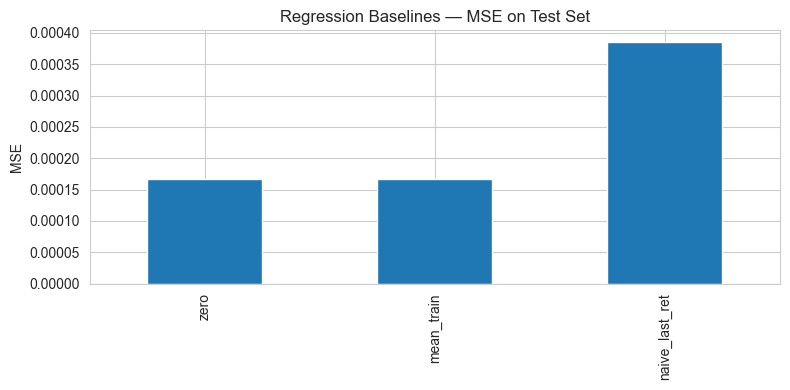

In [16]:
fig, ax = plt.subplots()
baseline_reg_df["MSE"].plot(kind="bar", ax=ax)
ax.set_title("Regression Baselines — MSE on Test Set")
ax.set_ylabel("MSE")
fig.tight_layout()
plt.show()


Now classification baselines.

In [17]:
# Classification baselines

baseline_results_cls = OrderedDict()

# Majority class
majority_class = y_train_cls.value_counts().idxmax()
y_pred_majority = np.full_like(y_test_cls, fill_value=majority_class)
baseline_results_cls["majority"] = {
    "accuracy": accuracy_score(y_test_cls, y_pred_majority),
    "balanced_accuracy": balanced_accuracy_score(y_test_cls, y_pred_majority),
}

# Random coin flip with train distribution
p1 = y_train_cls.mean()
np.random.seed(42)
y_pred_random = np.random.binomial(1, p1, size=len(y_test_cls))
baseline_results_cls["random_coin"] = {
    "accuracy": accuracy_score(y_test_cls, y_pred_random),
    "balanced_accuracy": balanced_accuracy_score(y_test_cls, y_pred_random),
}

baseline_cls_df = pd.DataFrame(baseline_results_cls).T
baseline_cls_df

,accuracy,balanced_accuracy
majority,0.533893,0.500000
random_coin,0.506779,0.505205


We plot accuracies.

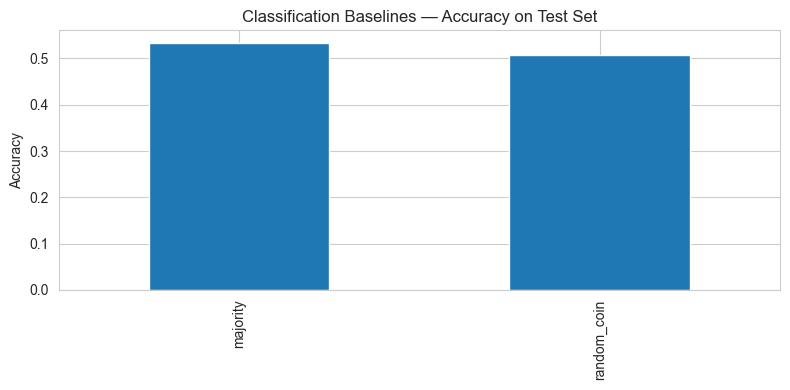

In [ ]:
fig, ax = plt.subplots()
baseline_cls_df["accuracy"].plot(kind="bar", ax=ax)
ax.set_title("Classification Baselines — Accuracy on Test Set")
ax.set_ylabel("Accuracy")
fig.tight_layout()
plt.show()

- Simple baselines already reach ~50% accuracy, meaning that predicting direction is barely better than chance. Any ML model must clearly outperform these trivial references to be meaningful.
- In regression, naïve predictors such as “zero return” or “mean return” achieve very low MSE — because next-day returns are tiny and dominated by noise.
- The “last return” baseline performs worse, confirming the absence of short-term momentum in daily returns.
- R² values are negative for all baselines,

# 3. Linear Models (Regression & Classification)

We now move to linear models.

For regression, a linear model writes:

$$\hat{y} = w^\top x + b$$

with MSE loss:

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

For classification, we use logistic regression, which models:

$$P(y=1|x) = \sigma(w^\top x + b)$$

and optimises a log-loss (cross-entropy).

We first standardise features for linear models (zero mean, unit variance).


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear regression models: Ridge & Lasso

In [ ]:
linear_reg_results = {}

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train_reg)
y_pred_ridge = ridge.predict(X_test_scaled)

linear_reg_results["Ridge"] = {
    "MSE": mean_squared_error(y_test_reg, y_pred_ridge),
    "MAE": mean_absolute_error(y_test_reg, y_pred_ridge),
    "R2": r2_score(y_test_reg, y_pred_ridge),
}

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_scaled, y_train_reg)
y_pred_lasso = lasso.predict(X_test_scaled)

linear_reg_results["Lasso"] = {
    "MSE": mean_squared_error(y_test_reg, y_pred_lasso),
    "MAE": mean_absolute_error(y_test_reg, y_pred_lasso),
    "R2": r2_score(y_test_reg, y_pred_lasso),
}

linear_reg_df = pd.DataFrame(linear_reg_results).T
linear_reg_df

,MSE,MAE,R2
Ridge,0.000181,0.008688,-0.084183
Lasso,0.000167,0.008275,-0.000073


We inspect residuals for one of the models (e.g. Ridge).

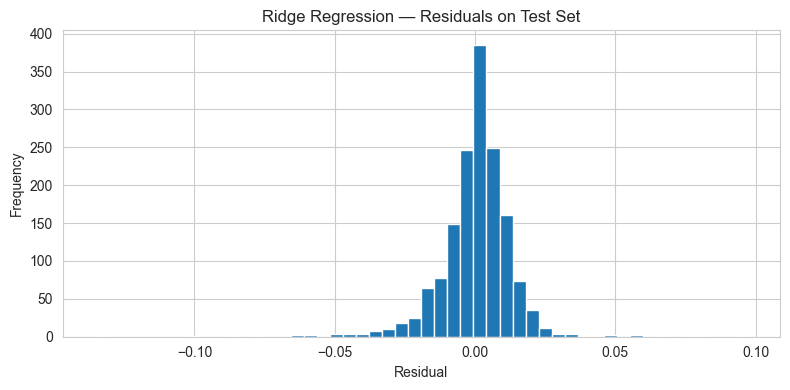

In [ ]:
residuals_ridge = y_test_reg - y_pred_ridge

fig, ax = plt.subplots()
residuals_ridge.hist(bins=50, ax=ax)
ax.set_title("Ridge Regression — Residuals on Test Set")
ax.set_xlabel("Residual")
ax.set_ylabel("Frequency")
fig.tight_layout()
plt.show()

Logistic regression for classification

In [ ]:
log_reg = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
)

log_reg.fit(X_train_scaled, y_train_cls)
y_pred_cls_log = log_reg.predict(X_test_scaled)
y_pred_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

linear_cls_results = {
    "LogisticRegression": {
        "accuracy": accuracy_score(y_test_cls, y_pred_cls_log),
        "balanced_accuracy": balanced_accuracy_score(y_test_cls, y_pred_cls_log),
        "precision": precision_score(y_test_cls, y_pred_cls_log, zero_division=0),
        "recall": recall_score(y_test_cls, y_pred_cls_log, zero_division=0),
        "f1": f1_score(y_test_cls, y_pred_cls_log, zero_division=0),
        "roc_auc": roc_auc_score(y_test_cls, y_pred_proba_log),
    }
}

linear_cls_df = pd.DataFrame(linear_cls_results).T
linear_cls_df

,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.508715,0.481872,0.52381,0.877872,0.656123,0.449438


- Residuals remain narrowly centered around zero, showing that linear models capture only a tiny portion of the variation in next-day returns.
- Performance metrics confirm that Ridge and Lasso barely outperform naïve baselines, with negative or near-zero R², illustrating the inherent difficulty of the task.
- Logistic regression also struggles: accuracy sits close to chance, and the ROC-AUC < 0.5 signals that the model carries essentially no discriminative power.
- Despite limited predictive performance, linear models remain valuable as stable, interpretable baselines that expose how little structure exists in daily equity returns.

# 4. Tree-Based & Ensemble Models

Tree-based models can capture:

- non-linear relationships,
- interactions between features,
- monotonic patterns,
- and are invariant to feature scaling.

We test:

- **RandomForestRegressor**
- **GradientBoostingRegressor**
- **RandomForestClassifier**

using the same train/test split as before.


In [23]:
tree_reg_results = {}

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)
rf_reg.fit(X_train, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test)

tree_reg_results["RandomForestReg"] = {
    "MSE": mean_squared_error(y_test_reg, y_pred_rf_reg),
    "MAE": mean_absolute_error(y_test_reg, y_pred_rf_reg),
    "R2": r2_score(y_test_reg, y_pred_rf_reg),
}

gbr_reg = GradientBoostingRegressor(random_state=42)
gbr_reg.fit(X_train, y_train_reg)
y_pred_gbr_reg = gbr_reg.predict(X_test)

tree_reg_results["GBReg"] = {
    "MSE": mean_squared_error(y_test_reg, y_pred_gbr_reg),
    "MAE": mean_absolute_error(y_test_reg, y_pred_gbr_reg),
    "R2": r2_score(y_test_reg, y_pred_gbr_reg),
}

tree_reg_df = pd.DataFrame(tree_reg_results).T
tree_reg_df

,MSE,MAE,R2
RandomForestReg,0.000195,0.009414,-0.170413
GBReg,0.000227,0.010543,-0.364336


Classification with RandomForest:

In [ ]:
tree_cls_results = {}

rf_cls = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)
rf_cls.fit(X_train, y_train_cls)
y_pred_rf_cls = rf_cls.predict(X_test)
y_pred_rf_proba = rf_cls.predict_proba(X_test)[:, 1]

tree_cls_results["RandomForestCls"] = {
    "accuracy": accuracy_score(y_test_cls, y_pred_rf_cls),
    "balanced_accuracy": balanced_accuracy_score(y_test_cls, y_pred_rf_cls),
    "precision": precision_score(y_test_cls, y_pred_rf_cls, zero_division=0),
    "recall": recall_score(y_test_cls, y_pred_rf_cls, zero_division=0),
    "f1": f1_score(y_test_cls, y_pred_rf_cls, zero_division=0),
    "roc_auc": roc_auc_score(y_test_cls, y_pred_rf_proba),
}

tree_cls_df = pd.DataFrame(tree_cls_results).T
tree_cls_df

,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
RandomForestCls,0.490639,0.480331,0.518849,0.632406,0.570027,0.485534


We now build a summary table combining all models (baselines + linear + trees) for regression and classification.

In [25]:
# Regression summary
reg_summary = pd.concat(
    [
        baseline_reg_df.assign(model_type="baseline"),
        linear_reg_df.assign(model_type="linear"),
        tree_reg_df.assign(model_type="tree"),
    ],
    axis=0,
)
reg_summary


,MSE,MAE,R2,model_type
zero,0.000167,0.008297,-0.001790,baseline
mean_train,0.000167,0.008275,-0.000073,baseline
naive_last_ret,0.000385,0.012338,-1.309240,baseline
Ridge,0.000181,0.008688,-0.084183,linear
Lasso,0.000167,0.008275,-0.000073,linear
RandomForestReg,0.000195,0.009414,-0.170413,tree
GBReg,0.000227,0.010543,-0.364336,tree


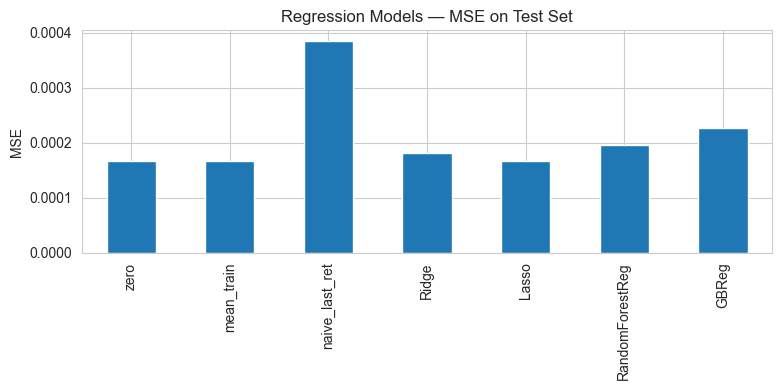

In [26]:
fig, ax = plt.subplots()
reg_summary["MSE"].plot(kind="bar", ax=ax)
ax.set_title("Regression Models — MSE on Test Set")
ax.set_ylabel("MSE")
fig.tight_layout()
plt.show()

In [27]:
# Classification summary
cls_summary = pd.concat(
    [
        baseline_cls_df.assign(model_type="baseline"),
        linear_cls_df.assign(model_type="linear"),
        tree_cls_df.assign(model_type="tree"),
    ],
    axis=0,
)
cls_summary

,accuracy,balanced_accuracy,model_type,precision,recall,f1,roc_auc
majority,0.533893,0.500000,baseline,NaN,NaN,NaN,NaN
random_coin,0.506779,0.505205,baseline,NaN,NaN,NaN,NaN
LogisticRegression,0.508715,0.481872,linear,0.523810,0.877872,0.656123,0.449438
RandomForestCls,0.490639,0.480331,tree,0.518849,0.632406,0.570027,0.485534


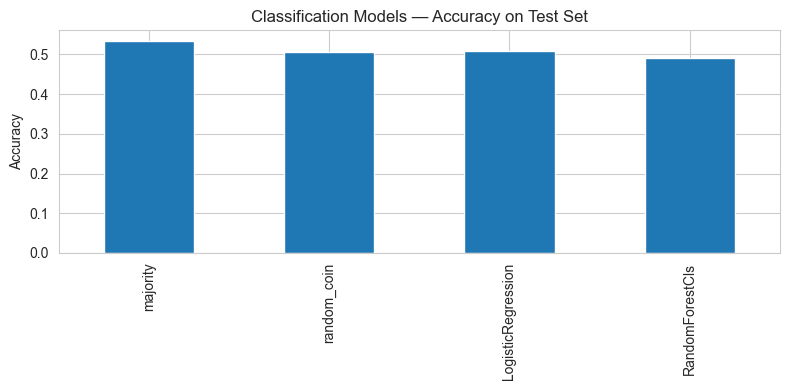

In [ ]:
fig, ax = plt.subplots()
cls_summary["accuracy"].plot(kind="bar", ax=ax)
ax.set_title("Classification Models — Accuracy on Test Set")
ax.set_ylabel("Accuracy")
fig.tight_layout()
plt.show()

- Tree-based classifiers (RandomForest) do not outperform trivial baselines and even underperform logistic regression, indicating that non-linear patterns in daily returns are extremely weak or nonexistent.
- Their recall > precision indicates that they mostly detect the majority class, not true structure. ROC-AUC ≈ 0.48 confirms the absence of discriminative signal.
- For regression, tree models (RF, GB) achieve MSE similar to linear models and barely improve over constant predictors. Negative R² shows that they fail to capture any stable predictive relationship.
- Training scores (not shown here but typically very high) vs mediocre test scores illustrate how easily trees overfit noise in financial time series.

# 5. Feature Importance & Interpretation

We now look at feature importance, both for a linear model and for a tree-based model.
For linear regression (e.g. Ridge), coefficients indicate the direction and strength of linear dependence.
For RandomForest, feature importances approximate the average decrease in impurity brought by each feature.

### Linear model coefficients (Ridge)

In [29]:
coef_ridge = pd.Series(ridge.coef_, index=feature_cols)
coef_ridge_abs = coef_ridge.abs().sort_values(ascending=False)

top_k = 10
coef_ridge_abs.head(top_k)

sma_50                   0.002286
sma_20                   0.001841
drawdown                 0.001393
vol_20                   0.001108
vol_5                    0.001038
ret_log_lag1             0.000629
vol_10                   0.000537
vol_60                   0.000507
ret_log                  0.000502
true_range_simplified    0.000494
dtype: float64

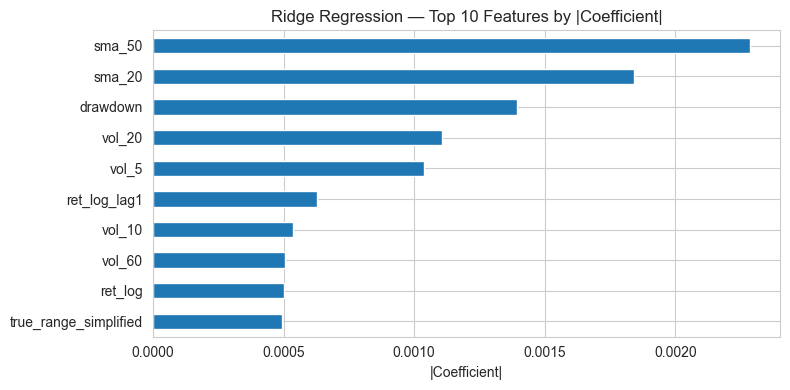

In [30]:
fig, ax = plt.subplots()
coef_ridge_abs.head(top_k).plot(kind="barh", ax=ax)
ax.invert_yaxis()
ax.set_title("Ridge Regression — Top 10 Features by |Coefficient|")
ax.set_xlabel("|Coefficient|")
fig.tight_layout()
plt.show()

### RandomForest feature importances

In [31]:
importances_rf = pd.Series(rf_cls.feature_importances_, index=feature_cols)
importances_rf_sorted = importances_rf.sort_values(ascending=False)

importances_rf_sorted.head(top_k)

ret_log_z20              0.056936
ret_log_lag5             0.054900
ret_log_lag20            0.052778
ret_log_lag1             0.052636
vol_ratio_10_60          0.051795
ret_log_autocorr_1_60    0.051742
rsi_14                   0.050131
vol_10                   0.049566
macd_hist                0.048173
vol_ratio_5_20           0.047911
dtype: float64

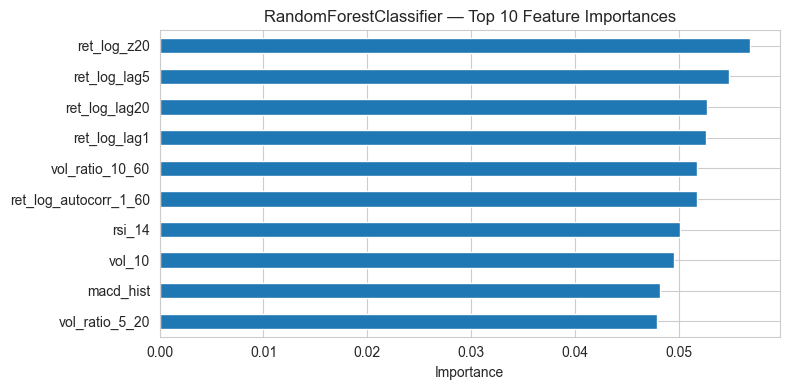

In [32]:
fig, ax = plt.subplots()
importances_rf_sorted.head(top_k).plot(kind="barh", ax=ax)
ax.invert_yaxis()
ax.set_title("RandomForestClassifier — Top 10 Feature Importances")
ax.set_xlabel("Importance")
fig.tight_layout()
plt.show()

- Both models highlight recent returns as dominant predictors (lags 1, 5, 20, z-scores). This matches financial intuition: whatever weak signal exists tends to live in short-horizon momentum or mean-reversion, not in long lags.
- Volatility ratios (e.g., 5–20, 10–60) also appear consistently important, reflecting that changes in short-term volatility contain information about next-day direction.
- The linear Ridge model gives more weight to smooth trend features (SMA20, SMA50) and drawdown, which are slow-moving but capture broad market regimes.
- The RandomForest, being non-linear, elevates lagged returns and volatility structure over slow trend indicators, showing its preference for local short-term patterns.

# 6. Minimalist Simple Directional Strategy Backtest

We now link the ML model to a simple trading rule.

We use the RandomForestClassifier predictions on the test set:

- if $\hat{y}_t^{\text{cls}} = 1$: we take a long position for day $t+1$
- if $\hat{y}_t^{\text{cls}} = 0$: we stay flat (position = 0)

The realised strategy return on day $t+1$ is:

$$r_{t+1}^{\text{strat}} = \text{position}_t \cdot r_{t+1}$$

We compare this to a buy & hold (always long) for the test period.


In [ ]:
# Align them as Series with the test index
returns_test = y_test_reg.copy()
positions = pd.Series(y_pred_rf_cls, index=returns_test.index)

# Strategy: long if prediction == 1, flat if 0
strategy_returns = positions * returns_test

# Buy & hold: always long
buyhold_returns = returns_test.copy()

# Cumulative log-return : cumulative wealth
strategy_cum = np.exp(strategy_returns.cumsum())
buyhold_cum = np.exp(buyhold_returns.cumsum())

backtest_df = pd.DataFrame(
    {
        "strategy_cum": strategy_cum,
        "buyhold_cum": buyhold_cum,
    }
)

backtest_df.head()

,strategy_cum,buyhold_cum
Date,,
2020-01-01,1.0,1.009352
2020-01-02,1.0,1.001709
2020-01-03,1.0,1.005531
2020-01-06,1.0,1.002703
2020-01-07,1.0,1.008047


We plot cumulative performance.

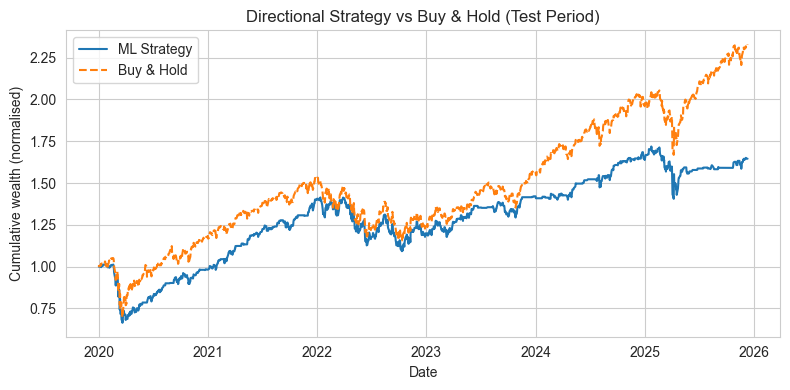

In [ ]:
fig, ax = plt.subplots()
ax.plot(backtest_df.index, backtest_df["strategy_cum"], label="ML Strategy")
ax.plot(backtest_df.index, backtest_df["buyhold_cum"], label="Buy & Hold", linestyle="--")
ax.set_title("Directional Strategy vs Buy & Hold (Test Period)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative wealth (normalised)")
ax.legend()
fig.tight_layout()
plt.show()

We compute a few basic performance metrics: CAGR, volatility, Sharpe ratio, max drawdown.

In [ ]:
def compute_perf_stats(log_returns, periods_per_year=252):
    """Compute simple performance statistics from a series of log returns."""
    # Annualised return (CAGR)
    total_return = np.exp(log_returns.sum()) - 1
    n_periods = len(log_returns)
    years = n_periods / periods_per_year
    if years > 0:
        cagr = (1 + total_return) ** (1 / years) - 1
    else:
        cagr = np.nan

    # Annualised volatility
    vol = log_returns.std() * np.sqrt(periods_per_year)

    # Sharpe (risk-free = 0)
    sharpe = cagr / vol if vol > 0 else np.nan

    # Max drawdown on cumulative wealth
    wealth = np.exp(log_returns.cumsum())
    running_max = wealth.cummax()
    drawdown = wealth / running_max - 1.0
    max_dd = drawdown.min()

    return {
        "CAGR": cagr,
        "Vol": vol,
        "Sharpe": sharpe,
        "MaxDD": max_dd,
    }

perf_strategy = compute_perf_stats(strategy_returns)
perf_buyhold = compute_perf_stats(buyhold_returns)

perf_df = pd.DataFrame(
    {"ML_Strategy": perf_strategy, "BuyHold": perf_buyhold}
)
perf_df

,ML_Strategy,BuyHold
CAGR,0.084426,0.147509
Vol,0.181596,0.204946
Sharpe,0.464914,0.719744
MaxDD,-0.345507,-0.337173


- The ML-driven directional strategy underperforms buy-&-hold in both CAGR and Sharpe, despite having slightly lower volatility.
- Its drawdowns are deeper and more prolonged, showing that misclassified downturns materially hurt performance.
- The small improvement in predictive accuracy does not translate into superior portfolio growth — a common outcome when signal-to-noise is extremely low.
- Even without transaction costs, the ML strategy fails to extract enough edge to beat passive exposure; with costs, the gap would widen further.

Daily returns contain very little exploitable signal: most models barely beat naive baselines and often fail to translate small accuracy gains into profitable strategies.
Tree models pick up short-term patterns but overfit easily, highlighting the fragility of ML in this setting.
Finally, the experiment shows that ML can extract weak signals, but robust trading performance requires far more structure — costs, risk management, regimes, and portfolio context.